## <font color = 'darkblue'> **Etapas para chegar no melhor modelo de regressão para este projeto**

1) Executar uma boa Análise Exploratória

2) **Avaliar os dados geográficos com Geopandas**

3) Desenvolver notebook "padrão" para o projeto de Machine Learning, com funções que podem facilitar testes de diferentes modelos

4) Aprimorar o modelo de Machine Learning, seguindo as etapas abaixo:
    - Linear Regression com preprocessamento só colunas categóricas, comparando com Dummy Regressor
    - Avaliar se a transformação de target melhora modelo, e testar qual transformação de target é melhor (PowerTransform ou Quantile Transform)
    - Testar diferentes tipos de preprocessamento para colunas numéricas (somente RobustScaler ou Standard Scaler + Power Transform) com a melhor transformação de target
    - Aplicar Polynomial Features para verificar qual grau polinomial gera o melhor modelo
    - Substituir o Linear Regression pelo Elastic Net para verificar se a regularização dos dados melhora o modelo
    - Substituir o ElasticNet pelo Ridge, testando os melhores parâmetros do modelo Ridge, e verificar os resultado para finalmente obter melhor modelo de regressão para esse projeto

5) Salvar o melhor modelo

***OBS**: As etapas deste projeto executadas neste notebook estão destacadas de negrito*

# Análise dos Dados Geográficos

## GeoPandas

GeoPandas é uma biblioteca do Python que estende as funcionalidades do Pandas, permitindo que se trabalhe de maneira eficiente com dados geoespaciais, permitindo manipular, analisar e visualizar dados geoespaciais de forma integrada e simplificada.

A principal característica do GeoPandas é a capacidade de lidar com geometrias (pontos, linhas, polígonos, etc.) em colunas especiais chamadas de `GeoSeries`. Essas geometrias podem ser usadas para representar entidades espaciais, como localizações geográficas, fronteiras de cidades, ou trajetórias. 

GeoPandas também se integra bem com bibliotecas de visualização como Matplotlib, facilitando a criação de mapas e gráficos baseados em dados espaciais. 

https://geopandas.org/en/stable/index.html

In [39]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from shapely.geometry import Point

from src.config import DADOS_LIMPOS, DADOS_GEO_ORIGINAIS, DADOS_GEO_MEDIAN, PASTA_RELATORIOS

# DADOS_GEO_ORIGINAIS está usando o arquivo "california_counties.geojson" da pasta dados e que foi baixado da internet (digitar no google "california geojson")
# Podemos pesquisar "países da europa geojson" ou "estados do brasil geojson" para ver o arquivo do mapa que queremos usar

sns.set_theme(style="white", palette="bright")

PALETTE = "coolwarm"
SCATTER_ALPHA = 0.2

In [40]:
import warnings

# Suprime todos os warnings
warnings.filterwarnings("ignore")

In [41]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

O melhor termo para traduzir **"county"** seria **"condado"**. Nos EUA, os **counties** (condados) são subdivisões dos estados, com certa autonomia administrativa, similar às regiões intermediárias entre estados e municípios no Brasil. No entanto, a melhor correspondência prática no Brasil, seria com os **municípios**, que são as subdivisões administrativas dos estados brasileiros.

In [43]:
gdf_counties = gpd.read_file(DADOS_GEO_ORIGINAIS)

gdf_counties.head()

,name,fullname,abbrev,abcode,ansi,geometry
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18..."
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933..."
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9..."
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7..."
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3..."


In [44]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


<font color='blue'> **OBS:** Precisamos converter a latitude e longitude num código que possa ser interpreado pelo Geopandas

In [45]:
pontos = [Point(long, lat) for long, lat in zip(df['longitude'], df['latitude'])]     # List Comprehension para unir longitude e latitude

pontos[:5]

[<POINT (-122.23 37.88)>,
 <POINT (-122.22 37.86)>,
 <POINT (-122.26 37.84)>,
 <POINT (-122.26 37.85)>,
 <POINT (-122.26 37.84)>]

In [46]:
gdf = gpd.GeoDataFrame(df, geometry=pontos)      # Transformando o dataframe em um geodataframe (gdf) com uma informação de geometria adequada

gdf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,geometry
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591,POINT (-122.23 37.88)
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797,POINT (-122.22 37.86)
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274,POINT (-122.26 37.84)
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679,POINT (-122.26 37.85)
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216,POINT (-122.26 37.84)


In [47]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-nu

<font color='blue'> **OBS:** Agora precisamos entender se essa coluna "geometry" está no mesmo sistema de informação do arquivo ".geojson" referente aos condados da california, pra podermos conectar adequadamente os dados

In [48]:
gdf_counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
gdf = gdf.set_crs(epsg=4326)      # Para configurar o dataframe pra ficar no formato EPSG 4326, que é o mais comum usado, e também o formato que está "gdf_counties"

In [50]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins

https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html

In [51]:
gdf_joined = gpd.sjoin(gdf, gdf_counties, how='left', predicate='within')     

gdf_joined.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,rooms_per_household,population_per_household,bedrooms_per_room,geometry,index_right,name,fullname,abbrev,abcode,ansi
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,...,6.984127,2.555556,0.146591,POINT (-122.23 37.88),34.0,Alameda,Alameda County,ALA,c001,001
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,...,6.238137,2.109842,0.155797,POINT (-122.22 37.86),34.0,Alameda,Alameda County,ALA,c001,001
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,...,4.294117,2.026891,0.260274,POINT (-122.26 37.84),34.0,Alameda,Alameda County,ALA,c001,001
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,...,4.242424,2.640152,0.252679,POINT (-122.26 37.85),34.0,Alameda,Alameda County,ALA,c001,001
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,...,5.343676,2.362768,0.203216,POINT (-122.26 37.84),34.0,Alameda,Alameda County,ALA,c001,001


In [52]:
gdf_counties.iloc[12]          # O índice 12 do geotaframe dos condados é referente às informações daquele condado

name                                                     Yuba
fullname                                          Yuba County
abbrev                                                    YUB
abcode                                                   c058
ansi                                                      115
geometry    POLYGON ((-121.01794117107198 39.5919167593742...
Name: 12, dtype: object

Colunas que podemos eliminar:
- index_right
- fullname
- abcode
- ansi

In [53]:
gdf_joined = gdf_joined.drop(
    columns = ['index_right', 'fullname', 'abcode', 'ansi']
)

gdf_joined.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,geometry,name,abbrev
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591,POINT (-122.23 37.88),Alameda,ALA
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797,POINT (-122.22 37.86),Alameda,ALA
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274,POINT (-122.26 37.84),Alameda,ALA
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679,POINT (-122.26 37.85),Alameda,ALA
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216,POINT (-122.26 37.84),Alameda,ALA


In [54]:
gdf_joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 17564 entries, 0 to 17563
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  f

**OBS:** Podemos ver que temos alguns valores nulos da coluna 'name' e 'abbrev', talvez o geodataframe não conseguiu identificar a qual condado pertencia aquele ponto

In [55]:
gdf_joined.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
median_income_cat             0
rooms_per_household           0
population_per_household      0
bedrooms_per_room             0
geometry                      0
name                        148
abbrev                      148
dtype: int64

In [56]:
gdf_joined[gdf_joined.isnull().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,geometry,name,abbrev
1507,-124.300003,41.799999,19,2672,552,1298,478,1.9797,85800,NEAR OCEAN,2,5.589958,2.715481,0.206587,POINT (-124.3 41.8),NaN,NaN
1508,-124.230003,41.750000,11,3159,616,1343,479,2.4805,73200,NEAR OCEAN,2,6.594990,2.803758,0.194998,POINT (-124.23 41.75),NaN,NaN
1511,-124.220001,41.730000,28,3003,699,1530,653,1.7038,78300,NEAR OCEAN,2,4.598775,2.343032,0.232767,POINT (-124.22 41.73),NaN,NaN
1517,-124.300003,41.840000,17,2677,531,1244,456,3.0313,103600,NEAR OCEAN,3,5.870614,2.728070,0.198356,POINT (-124.3 41.84),NaN,NaN
1521,-119.940002,38.959999,20,1451,386,467,255,1.5536,212500,INLAND,2,5.690196,1.831372,0.266023,POINT (-119.94 38.96),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17198,-119.300003,34.270000,17,1527,503,688,423,1.6007,187500,NEAR OCEAN,2,3.609929,1.626478,0.329404,POINT (-119.3 34.27),NaN,NaN
17199,-119.290001,34.259998,32,3295,764,1344,600,3.6007,395500,NEAR OCEAN,3,5.491667,2.240000,0.231866,POINT (-119.29 34.26),NaN,NaN
17201,-119.290001,34.230000,22,2486,608,709,523,2.9018,275000,NEAR OCEAN,2,4.753346,1.355641,0.244570,POINT (-119.29 34.23),NaN,NaN
17232,-119.230003,34.150002,18,6213,1188,2679,1000,3.7480,380400,NEAR OCEAN,3,6.213000,2.679000,0.191212,POINT (-119.23 34.15),NaN,NaN


**Observações**:

- Olhando a latitude e a longitude desses pontos que ficaram fora do gráfico, percebemos que alguns deles estão no mar. Pode ser algum erro dos dados, ou se formos pensar que os dados são a média da longitude e latitude de todas as residências de um determinado condado, pode ser que essa média / mediana acabe ficano no oceano em alguns casos.

- Podemos alocar a essas pontos o condado mais próximo? Sim, é o que iremos fazer

- Mas poderíamos eliminar esses pontos também, já que tem apenas 148 registros

In [57]:
linhas_faltantes = gdf_joined[gdf_joined.isnull().any(axis=1)].index

linhas_faltantes

Index([ 1507,  1508,  1511,  1517,  1521,  2154,  2193,  2201,  2203,  2219,
       ...
       15747, 15748, 15752, 15755, 15756, 17198, 17199, 17201, 17232, 17258],
      dtype='int64', length=148)

In [58]:
gdf_counties['centroid'] = gdf_counties.centroid

gdf_counties.head()

,name,fullname,abbrev,abcode,ansi,geometry,centroid
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18...",POINT (-122.54047 41.59268)
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933...",POINT (-123.89681 41.74299)
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9...",POINT (-120.72517 41.58987)
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7...",POINT (-123.11264 40.65063)
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3...",POINT (-122.04016 40.76344)


#### **Fazendo a análise de uma linha específica que não possui o condado ('name') definido - Linha 1507**

In [59]:
gdf_joined.loc[1507]

longitude                                                     -124.300003
latitude                                                        41.799999
housing_median_age                                                     19
total_rooms                                                          2672
total_bedrooms                                                        552
population                                                           1298
households                                                            478
median_income                                                      1.9797
median_house_value                                                  85800
ocean_proximity                                                NEAR OCEAN
median_income_cat                                                       2
rooms_per_household                                              5.589958
population_per_household                                         2.715481
bedrooms_per_room                     

In [60]:
gdf_counties['centroid'].distance( gdf_joined.loc[1507, 'geometry']  )   # Será calculado a distancia do ponto índice 1507 para o centroide de cada um dos condados do gdf_counties

0      1.771700
1      0.407204
2      3.581004
3      1.652539
4      2.486229
5      3.872982
6      1.181051
7      2.658962
8      3.899362
9      3.440403
10     2.913231
11     4.386820
12     3.885950
13     3.111850
14     4.326303
15     3.336570
16     2.528645
17     3.799275
18     4.508214
19     4.834879
20     3.930031
21     5.506539
22     3.568571
23     3.837241
24     4.467937
25     6.649118
26     4.955842
27     4.248938
28     5.192143
29     5.754299
30     4.910558
31     4.069320
32     4.533433
33     5.374753
34     4.784590
35     6.091522
36     6.448327
37     4.438089
38     4.775127
39     5.836867
40     6.858891
41     5.258028
42     8.685359
43     5.271193
44     6.114297
45     7.834746
46     7.271996
47     6.366951
48    10.694858
49     8.527644
50     7.503716
51     9.007875
52     8.314811
53    11.571357
54    10.407882
55    12.512826
56     9.633791
57    11.578843
dtype: float64

In [61]:
gdf_counties['centroid'].distance(gdf_joined.loc[1507, 'geometry']).idxmin()      # Pegando o índice do valor mínimo da distância do centroide dos condados pro ponto do índice 1507

1

In [62]:
gdf_counties.loc[1]

name                                                Del Norte
fullname                                     Del Norte County
abbrev                                                    DNT
abcode                                                   c008
ansi                                                      015
geometry    MULTIPOLYGON (((-124.19097394913307 41.7361877...
centroid       POINT (-123.89681032594169 41.742987539381424)
Name: 1, dtype: object

**Para otimizar essa busca do condado para cada ponto nulo do gdf_joined acima, podemos criar uma função que faça isso, ela deve retornar valores para a coluna 'name' e 'abbrev'**

In [63]:
def condado_mais_proximo(linha_gdf_joined):
    ponto = linha_gdf_joined['geometry']
    distancias = gdf_counties['centroid'].distance(ponto)
    idx_condado_mais_proximo = distancias.idxmin()
    condado_mais_proximo = gdf_counties.loc[idx_condado_mais_proximo]
    return condado_mais_proximo[['name', 'abbrev']]

In [64]:
gdf_joined.loc[1507]

longitude                                                     -124.300003
latitude                                                        41.799999
housing_median_age                                                     19
total_rooms                                                          2672
total_bedrooms                                                        552
population                                                           1298
households                                                            478
median_income                                                      1.9797
median_house_value                                                  85800
ocean_proximity                                                NEAR OCEAN
median_income_cat                                                       2
rooms_per_household                                              5.589958
population_per_household                                         2.715481
bedrooms_per_room                     

In [65]:
condado_mais_proximo(gdf_joined.loc[1507])

name      Del Norte
abbrev          DNT
Name: 1, dtype: object

In [66]:
gdf_joined.loc[linhas_faltantes, ['name', 'abbrev']] = gdf_joined.loc[linhas_faltantes].apply(condado_mais_proximo, axis=1)

# Explicando "gdf_joined.loc[linhas_faltantes, ['name', 'abbrev']]" recebe 2 valores
# Esses valores são obtidos aplicando a funçaõ "condado_mais_proximo" com o método .apply() no geodataframe "gdf_joined" onde tinham linhas faltantes. 

In [67]:
gdf_joined.isnull().sum()    # Veja que zerou os registros nulos

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
median_house_value          0
ocean_proximity             0
median_income_cat           0
rooms_per_household         0
population_per_household    0
bedrooms_per_room           0
geometry                    0
name                        0
abbrev                      0
dtype: int64

In [68]:
gdf_joined.loc[linhas_faltantes, ['name', 'abbrev']]            # Veja as linhas que tinham registro nulos foram preenchidas

,name,abbrev
1507,Del Norte,DNT
1508,Del Norte,DNT
1511,Del Norte,DNT
1517,Del Norte,DNT
1521,Alpine,ALP
...,...,...
17198,Ventura,VEN
17199,Ventura,VEN
17201,Ventura,VEN
17232,Ventura,VEN


In [69]:
gdf_joined.loc[linhas_faltantes, ['name', 'abbrev']].value_counts()    # Os condados que mais tinham registros nulos estão no litoral do estado, talvez por pontos que estavam no oceado

name             abbrev
San Diego        SDG       29
Orange           ORA       27
Santa Cruz       SCR       20
Santa Barbara    SBA       13
San Francisco    SFO       11
San Luis Obispo  SLO       10
Ventura          VEN        9
Los Angeles      LAN        6
Del Norte        DNT        5
Humboldt         HUM        5
Mendocino        MEN        5
Monterey         MNT        4
San Mateo        SMT        2
Alpine           ALP        1
Marin            MRN        1
Name: count, dtype: int64

In [70]:
gdf_joined['name'].value_counts()        # Agora podemos ver quais condados possuem mais registros

name
Los Angeles        4827
San Diego          1467
Orange             1438
Santa Clara         824
Alameda             737
San Bernardino      729
Sacramento          622
Contra Costa        558
Riverside           504
Fresno              491
San Joaquin         387
Kern                353
Ventura             343
San Mateo           336
Sonoma              293
Stanislaus          282
Santa Barbara       261
Tulare              246
San Francisco       213
Santa Cruz          186
Solano              178
Monterey            170
Butte               144
San Luis Obispo     128
Marin               123
Merced              123
Shasta              119
Imperial            115
Humboldt            109
El Dorado           101
Placer              101
Napa                 94
Kings                86
Lake                 81
Nevada               80
Mendocino            77
Yolo                 74
Madera               74
Sutter               56
Yuba                 51
Tehama               47
Tuolumne   

<Axes: >

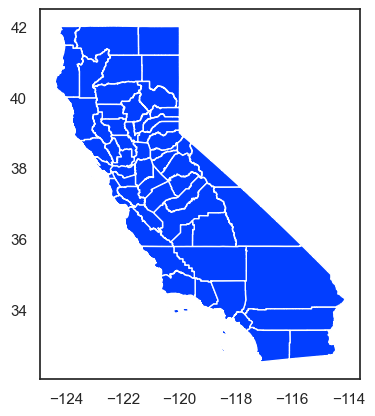

In [71]:
gdf_counties.plot()

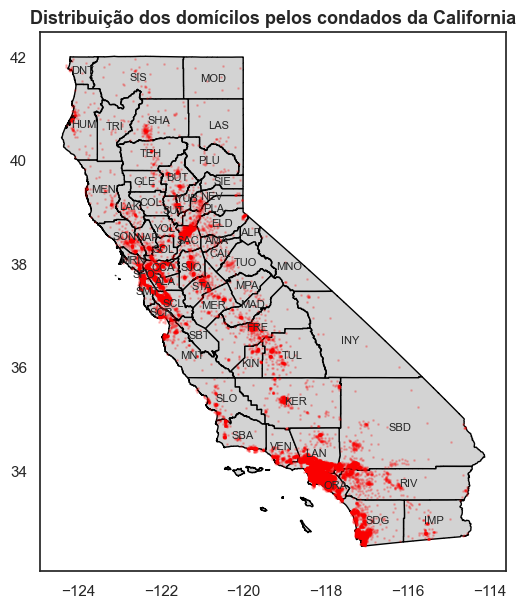

In [72]:
fig, ax = plt.subplots(figsize=(7, 7))

gdf_counties.plot(
    ax=ax,
    edgecolor='black',
    color='lightgrey'
)

ax.scatter(
    gdf_joined['longitude'], 
    gdf_joined['latitude'],
    color='red',
    s=1,
    alpha = SCATTER_ALPHA
)

for x, y, abbrev in zip(gdf_counties["centroid"].x, gdf_counties["centroid"].y, gdf_counties['abbrev']):
    ax.text(x, y, abbrev, fontsize=8, ha='center', va='center')               # "ha" = horizontal alligment e "va" = vertical allignment

ax.set_title("Distribuição dos domícilos pelos condados da California", fontweight='bold', fontsize=13)

fig.savefig(PASTA_RELATORIOS/"Domicilios por condado", dpi=300, bbox_inches='tight')

plt.show()

#### **Obtendo a "mediana" de cada feature por condado**

In [73]:
gdf_joined.groupby('name').median(numeric_only=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
name,,,,,,,,,,,,,
Alameda,-122.129997,37.709999,35.0,1938.0,399.0,1039.0,382.0,3.57140,188600.0,3.0,5.075716,2.719877,0.207107
Alpine,-119.860001,38.824997,18.5,1407.5,334.0,402.5,203.5,2.00180,165050.0,2.0,7.331940,2.027528,0.236384
Amador,-120.720001,38.430000,17.0,1787.0,357.0,767.0,305.0,3.04650,116700.0,3.0,6.058824,2.435115,0.191900
Butte,-121.599998,39.709999,22.0,1875.0,372.5,936.5,356.5,2.31895,86450.0,2.0,5.308164,2.514830,0.199470
Calaveras,-120.559998,38.200001,17.0,2745.0,559.0,1061.0,459.0,2.56670,101600.0,2.0,5.994983,2.488000,0.204878
Colusa,-122.044998,39.180000,34.0,1497.0,309.0,665.0,265.0,2.50920,68950.0,2.0,5.468055,2.895284,0.204971
Contra Costa,-122.070000,37.950001,27.0,2399.5,439.5,1143.0,425.5,4.37500,184950.0,3.0,5.677517,2.716802,0.184961
Del Norte,-124.169998,41.764999,19.0,2705.5,560.5,1290.0,486.5,2.22895,76650.0,2.0,5.523724,2.721776,0.207599
El Dorado,-120.709999,38.759998,17.0,2259.0,459.0,916.0,351.0,3.15000,128300.0,3.0,6.183511,2.676471,0.195695


In [74]:
gdf_counties.head(5)

,name,fullname,abbrev,abcode,ansi,geometry,centroid
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18...",POINT (-122.54047 41.59268)
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933...",POINT (-123.89681 41.74299)
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9...",POINT (-120.72517 41.58987)
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7...",POINT (-123.11264 40.65063)
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3...",POINT (-122.04016 40.76344)


In [75]:
gdf_counties = gdf_counties.merge(
    gdf_joined.groupby('name').median(numeric_only=True), 
    how='left', 
    left_on='name',
    right_index=True)

gdf_counties.head(5)

# Mas ainda faltam os registros dos dados categóricos do gdf_counties

,name,fullname,abbrev,abcode,ansi,geometry,centroid,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18...",POINT (-122.54047 41.59268),-122.544998,41.614998,23.0,2372.0,482.0,1111.0,427.0,2.17525,63950.0,2.0,5.848729,2.534145,0.201014
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933...",POINT (-123.89681 41.74299),-124.169998,41.764999,19.0,2705.5,560.5,1290.0,486.5,2.22895,76650.0,2.0,5.523724,2.721776,0.207599
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9...",POINT (-120.72517 41.58987),-120.529999,41.575001,22.0,2472.0,473.5,860.5,349.5,2.18775,50250.0,2.0,6.891730,2.537227,0.197889
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7...",POINT (-123.11264 40.65063),-123.125000,40.639999,18.5,954.0,211.5,369.5,154.0,1.90705,77100.0,2.0,6.116148,2.541760,0.225996
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3...",POINT (-122.04016 40.76344),-122.349998,40.570000,19.0,2251.0,463.0,1077.0,412.0,2.40790,85200.0,2.0,5.487129,2.714097,0.198684


In [76]:
gdf_joined[['name', 'ocean_proximity']].groupby('name').describe()

# Para variáveis categóricas não tem como calcular a mediana, mas podemos adotar a categoria que mais aparece de 'ocean_proximity' para cada condado, e isso é bem fácil notar abaixo

ocean_proximity                         
                          count unique         top  freq
name                                                    
Alameda                     737      3    NEAR BAY   617
Alpine                        2      1      INLAND     2
Amador                       27      1      INLAND    27
Butte                       144      1      INLAND   144
Calaveras                    25      1      INLAND    25
Colusa                       14      1      INLAND    14
Contra Costa                558      3    NEAR BAY   379
Del Norte                    16      2  NEAR OCEAN    14
El Dorado                   101      1      INLAND   101
Fresno                      491      1      INLAND   491
Glenn                        26      1      INLAND    26
Humboldt                    109      3  NEAR OCEAN    78
Imperial                    115      1      INLAND   115
Inyo                         18      1      INLAND    18
Kern                        353      1      INLAND   353
Kings                        86      1      INLAND    86
Lake                         81      2      INLAND    75
Lassen                       19      1      INLAND    19
Los Angeles                4827      3   <1H OCEAN  4180
Madera                       74      1      INLAND    74
Marin                       123      3    NEAR BAY    98
Mariposa                     17      1      INLAND    17
Mendocino                    77      3   <1H OCEAN    61
Merced                      123      1      INLAND   123
Modoc                         8      1      INLAND     8
Mono                          8      1      INLAND     8
Monterey                    170      3   <1H OCEAN   126
Napa                         94      3    NEAR BAY    59
Nevada                       80      1      INLAND    80
Orange                     1438      2   <1H OCEAN  1378
Placer                      101      1      INLAND   101
Plumas                       23      1      INLAND    23
Riverside                   504      2      INLAND   461
Sacramento                  622      1      INLAND   622
San Benito                   26      2      INLAND    25
San Bernardino              729      2      INLAND   725
San Diego                  1467      3  NEAR OCEAN   940
San Francisco               213      2    NEAR BAY   140
San Joaquin                 387      1      INLAND   387
San Luis Obispo             128      3   <1H OCEAN    70
San Mateo                   336      2  NEAR OCEAN   270
Santa Barbara               261      2  NEAR OCEAN   142
Santa Clara                 824      4   <1H OCEAN   724
Santa Cruz                  186      2  NEAR OCEAN   133
Shasta                      119      1      INLAND   119
Sierra                        5      1      INLAND     5
Siskiyou                     34      1      INLAND    34
Solano                      178      2      INLAND   115
Sonoma                      293      3   <1H OCEAN   273
Stanislaus                  282      1      INLAND   282
Sutter                       56      1      INLAND    56
Tehama                       47      1      INLAND    47
Trinity                      22      1      INLAND    22
Tulare                      246      1      INLAND   246
Tuolumne                     46      1      INLAND    46
Ventura                     343      3   <1H OCEAN   193
Yolo                         74      1      INLAND    74
Yuba                         51      1      INLAND    51

<font color ='blue'> **OBS**: Podemos obter a moda das variáveis categóricas através da função de agregação .agg(pd.Series.mode), e após isso fazer o .merge com o df dos condados

In [77]:
countie_ocean_prox = gdf_joined[['name', 'ocean_proximity']].groupby('name').agg(pd.Series.mode)
countie_ocean_prox

,ocean_proximity
name,
Alameda,NEAR BAY
Alpine,INLAND
Amador,INLAND
Butte,INLAND
Calaveras,INLAND
Colusa,INLAND
Contra Costa,NEAR BAY
Del Norte,NEAR OCEAN
El Dorado,INLAND


In [78]:
gdf_counties = gdf_counties.merge(
    countie_ocean_prox, 
    left_on = 'name',
    right_index = True 
)

gdf_counties.head(5)

,name,fullname,abbrev,abcode,ansi,geometry,centroid,longitude,latitude,housing_median_age,...,total_bedrooms,population,households,median_income,median_house_value,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18...",POINT (-122.54047 41.59268),-122.544998,41.614998,23.0,...,482.0,1111.0,427.0,2.17525,63950.0,2.0,5.848729,2.534145,0.201014,INLAND
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933...",POINT (-123.89681 41.74299),-124.169998,41.764999,19.0,...,560.5,1290.0,486.5,2.22895,76650.0,2.0,5.523724,2.721776,0.207599,NEAR OCEAN
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9...",POINT (-120.72517 41.58987),-120.529999,41.575001,22.0,...,473.5,860.5,349.5,2.18775,50250.0,2.0,6.891730,2.537227,0.197889,INLAND
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7...",POINT (-123.11264 40.65063),-123.125000,40.639999,18.5,...,211.5,369.5,154.0,1.90705,77100.0,2.0,6.116148,2.541760,0.225996,INLAND
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3...",POINT (-122.04016 40.76344),-122.349998,40.570000,19.0,...,463.0,1077.0,412.0,2.40790,85200.0,2.0,5.487129,2.714097,0.198684,INLAND


In [79]:
gdf_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   name                      58 non-null     object  
 1   fullname                  58 non-null     object  
 2   abbrev                    58 non-null     object  
 3   abcode                    58 non-null     object  
 4   ansi                      58 non-null     object  
 5   geometry                  58 non-null     geometry
 6   centroid                  58 non-null     geometry
 7   longitude                 58 non-null     float32 
 8   latitude                  58 non-null     float32 
 9   housing_median_age        58 non-null     float64 
 10  total_rooms               58 non-null     float64 
 11  total_bedrooms            58 non-null     float64 
 12  population                58 non-null     float64 
 13  households                58 non-null     fl

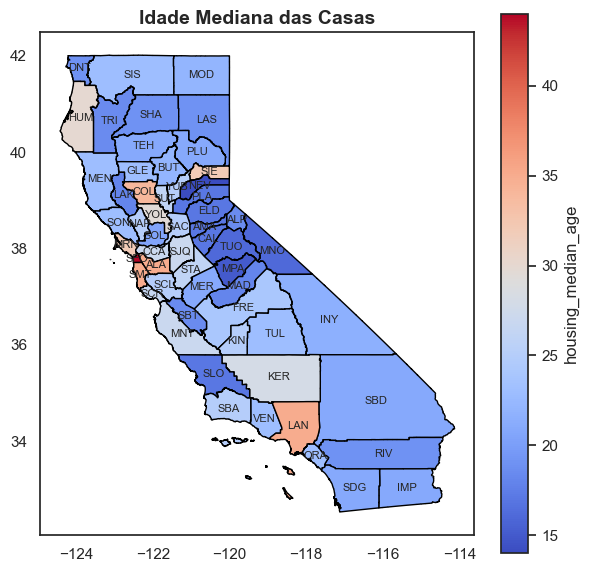

In [80]:
# Mapa - Idade Mediana das Casas

fig, ax = plt.subplots(figsize=(7,7))

gdf_counties.plot(
    ax=ax,
    edgecolor='black',
    column='housing_median_age',
    cmap='coolwarm',
    legend = True,
    legend_kwds = {'label': 'housing_median_age', 'orientation': 'vertical'}
)

for x, y, abbrev in zip(gdf_counties["centroid"].x, gdf_counties["centroid"].y, gdf_counties['abbrev']):
    ax.text(x, y, abbrev, fontsize=8, ha='center', va='center') 

ax.set_title('Idade Mediana das Casas', fontweight='bold', fontsize=14)

fig.savefig(PASTA_RELATORIOS/"Idade mediana dos domicilios", dpi=300, bbox_inches='tight')

plt.show()

Cuidados que temos que ter:
- Ter a mesma escala de cores para mapas cuja escala de cores advém de 2 features diferentes. 
- Poderíamos escolher uma outra escala de cores pra um dos mapas

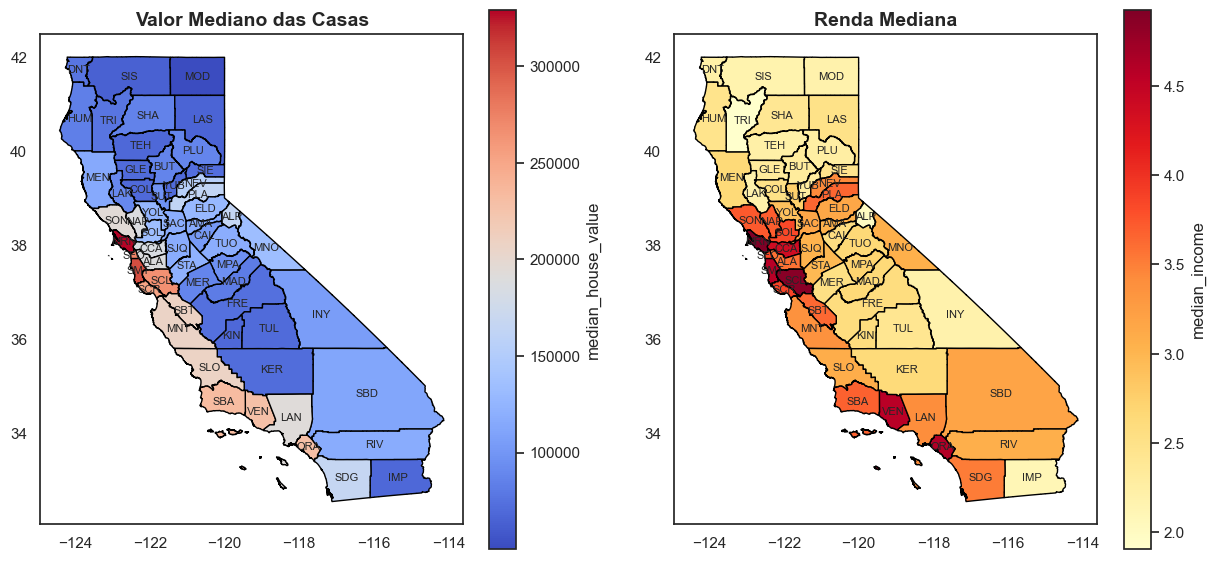

In [82]:
fig, axs = plt.subplots(1,2, figsize=(15,7))

gdf_counties.plot(
    ax=axs[0],
    edgecolor='black',
    column='median_house_value',
    cmap='coolwarm',
    legend = True,
    legend_kwds = {'label': 'median_house_value', 'orientation': 'vertical'}
)

gdf_counties.plot(
    ax=axs[1],
    edgecolor='black',
    column='median_income',
    cmap='YlOrRd',    # YlOrRd --> Yellor, Orande, Red
    legend = True,
    legend_kwds = {'label': 'median_income', 'orientation': 'vertical'}
)

for x, y, abbrev in zip(gdf_counties["centroid"].x, gdf_counties["centroid"].y, gdf_counties['abbrev']):
    axs[0].text(x, y, abbrev, fontsize=8, ha='center', va='center')               # "ha" = horizontal alligment e "va" = vertical allignment
    axs[1].text(x, y, abbrev, fontsize=8, ha='center', va='center')

axs[0].set_title('Valor Mediano das Casas', fontweight='bold', fontsize=14)
axs[1].set_title('Renda Mediana', fontweight='bold', fontsize=14)

fig.savefig(PASTA_RELATORIOS/"Valor Mediano dos Domicilios e Renda Mediana", dpi=300, bbox_inches='tight')

plt.show()

#### Exportando o geodataframe (formato parquet mesmo)

In [53]:
from pathlib import Path

WindowsPath('C:/Users/brcprrcchave/OneDrive - Blount/Documents/Treinamentos & Cursos/Ciência dos Dados Impressionador - Hashtag/Mod 14 - Regressao com Modelos Lineares/14.5 - Projeto de Regressão/notebooks')

In [56]:
gdf_counties.to_parquet(Path().resolve().parents[0] / 'dados' / "gdf_counties.parquet")
